In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

from pyModbusTCP.client import ModbusClient

import matplotlib.pyplot as plt

import numpy as np
import math
import time
import copy
import pdb
import pandas as pd

In [2]:
# this is one way to define a network
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden1, n_hidden2,n_hidden3, n_hidden4, n_output):
        super(Net, self).__init__()
        self.hidden  = nn.Linear(n_feature, n_hidden, bias=True)
        self.hidden1 = nn.Linear(n_hidden, n_hidden1, bias=True)   # hidden layer
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2, bias=True)   # hidden layer
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3, bias=True)   # hidden layer
        self.hidden4 = nn.Linear(n_hidden3, n_hidden4, bias=True)   # hidden layer
#         self.predict = nn.Linear(n_hidden2, n_output, bias=True)   # output layer
        self.predict = nn.Linear(n_hidden, n_output, bias=True)   # output layer

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))    # activation function for hidden layer
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        x = torch.sigmoid(self.hidden4(x))
        x = torch.sigmoid(self.predict(x))

        return x

net = Net(n_feature=3, n_hidden=5, n_hidden1=5, n_hidden2=5,n_hidden3=5, n_hidden4=5, n_output=1)     # define the network
print(net)  # net architecture


Net(
  (hidden): Linear(in_features=3, out_features=5, bias=True)
  (hidden1): Linear(in_features=5, out_features=5, bias=True)
  (hidden2): Linear(in_features=5, out_features=5, bias=True)
  (hidden3): Linear(in_features=5, out_features=5, bias=True)
  (hidden4): Linear(in_features=5, out_features=5, bias=True)
  (predict): Linear(in_features=5, out_features=1, bias=True)
)


In [3]:
class AdNN(object):
    def __init__ (self):
        self.zeta    = 0.00001
        self.dt      = 0.1
        self.un      = 0.0
        self.err     = 0.0
        self.err_1   = 0.0
        self.err_2   = 0.0
        self.loss    = torch.tensor([0.0])
        self.uNN     = 0.0
        self.u       = 0.0
        self.uMin    = 0
        self.uMax    = 7
        
    def calculateError(self,yr,yout):
        self.err_2  = self.err_1
        self.err_1  = self.err
        self.err    = 1.0*(yr-yout)

        return self.err
        
    def process(self):
        Xe = np.array([self.err,self.err_1,self.err_2])
        Xe = torch.from_numpy(Xe.T)
        Xe = torch.tensor(Xe,dtype=torch.float)

        self.uNN     = net(Xe)
        self.un      = (self.uNN.data.numpy()).item()
        self.u       = self.un * (self.uMax-self.uMin) + self.uMin

        return self.u
        
    def learn(self,alpha):
        self.zeta = alpha + alpha*np.abs(self.err)
        self.uNN.backward(torch.ones_like(self.uNN))

#         dW1 = net.hidden.weight.data  + self.zeta * self.err * net.hidden.weight.grad - 0.00000125*net.hidden.weight.data
#         dW2 = net.hidden1.weight.data + self.zeta * self.err * net.hidden1.weight.grad - 0.00000125*net.hidden1.weight.grad
#         dW3 = net.hidden2.weight.data + self.zeta * self.err * net.hidden2.weight.grad - 0.00000125*net.hidden2.weight.grad
#         dW4 = net.predict.weight.data + self.zeta * self.err * net.predict.weight.grad - 0.00000125*net.predict.weight.grad
        
        dW1 = net.hidden.weight.data  + self.zeta * self.err * net.hidden.weight.grad
        dW2 = net.hidden1.weight.data + self.zeta * self.err * net.hidden1.weight.grad
        dW3 = net.hidden2.weight.data + self.zeta * self.err * net.hidden2.weight.grad
        dW4 = net.hidden3.weight.data + self.zeta * self.err * net.hidden3.weight.grad
        dW5 = net.hidden4.weight.data + self.zeta * self.err * net.hidden4.weight.grad
        dW6 = net.predict.weight.data + self.zeta * self.err * net.predict.weight.grad
        
        net.hidden.weight.data  = dW1.clone().detach().requires_grad_(True)
        net.hidden1.weight.data = dW2.clone().detach().requires_grad_(True)
        net.hidden2.weight.data = dW3.clone().detach().requires_grad_(True)
        net.hidden3.weight.data = dW4.clone().detach().requires_grad_(True)
        net.hidden4.weight.data = dW5.clone().detach().requires_grad_(True)
        net.predict.weight.data = dW6.clone().detach().requires_grad_(True)

In [4]:
def plotGraph(tm,y,yr,er,uc,unn):

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.plot(tm,yr,label='reference')
    plt.plot(tm,y,label='response')
    plt.title('Respon')
    plt.xlabel('time (s)')
    plt.ylabel('speed (RPM)')
    plt.grid(True)
    
    plt.subplot(2,2,2)
    plt.plot(tm,er)
    plt.title('Error')
    plt.xlabel('time (s)')
    plt.ylabel('Error (RPM)')
    plt.grid(True)
    
    plt.subplot(2,2,3)
#     plt.plot(tm,uc,label='SMC')
#     plt.title('control signal')
    plt.plot(tm,unn,label='NN')
    plt.xlabel('time (s)')
    plt.ylabel('control signal (V)')
    plt.grid(True)
    plt.legend()
    plt.show()

<ipython-input-3-6771cd2db413>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xe = torch.tensor(Xe,dtype=torch.float)


35.0
35.01
35.02
35.03
35.04
35.050000000000004
35.06
35.07
35.08
35.09
35.1
35.11
35.12
35.13
35.14
35.15
35.160000000000004
35.17
35.18
35.19
35.2
35.21
35.22
35.230000000000004
35.24
35.25
35.26
35.27
35.28
35.29
35.300000000000004
35.31
35.32
35.33
35.34
35.35
35.36
35.37
35.38
35.39
35.4
35.410000000000004
35.42
35.43
35.44
35.45
35.46
35.47
35.480000000000004
35.49
35.5
35.51
35.52
35.53
35.54
35.550000000000004
35.56
35.57
35.58
35.59
35.6
35.61
35.62
35.63
35.64
35.65
35.660000000000004
35.67
35.68
35.69
35.7
35.71
35.72
35.730000000000004
35.74
35.75
35.76
35.77
35.78
35.79
35.800000000000004
35.81
35.82
35.83
35.84
35.85
35.86
35.87
35.88
35.89
35.9
35.910000000000004
35.92
35.93
35.94
35.95
35.96
35.97
35.980000000000004
35.99
36.0
36.01
36.02
36.03
36.04
36.050000000000004
36.06
36.07
36.08
36.09
36.1
36.11
36.12
36.13
36.14
36.15
36.160000000000004
36.17
36.18
36.19
36.2
36.21
36.22
36.230000000000004
36.24
36.25
36.26
36.27
36.28
36.29
36.300000000000004
36.31
36.32
36.33

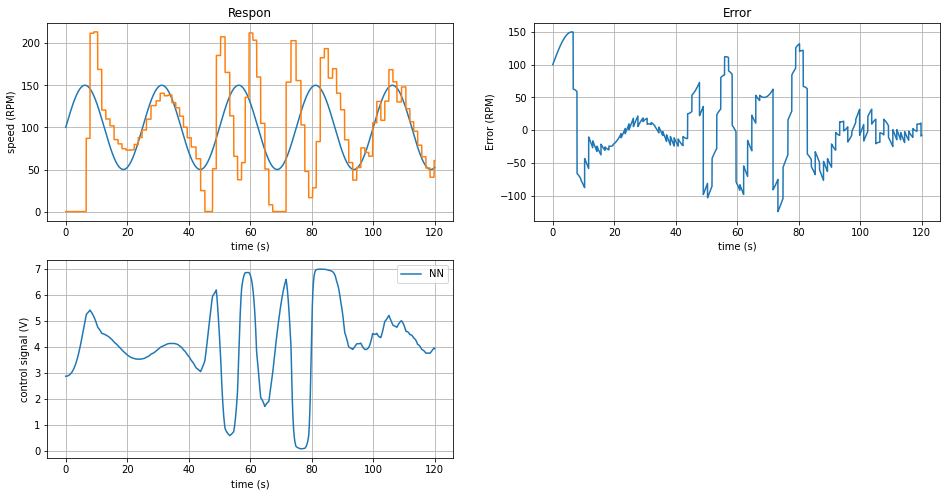

[[56.55209822]]


In [5]:
server_host="10.0.0.1"
server_port=502

x   = 0.0
x_1 = 0.0
x_2 = 0.0
y_1 = 0.0
y_2 = 0.0
yi  = 0.0
dt  = 0.01
u   = 0.0

c=ModbusClient()
c.host(server_host)
c.port(server_port)

sim_time = 120
cnt = int(sim_time/dt)
tim = np.arange(0.,sim_time,dt)

ypp    = []
tim    = [] #Simulation time (Sampling)
erracc = []
uacc   = []
usrcacc= []
unnacc = []
yr     = 1.0
yracc  = []
y      = 0.0
process_time=[]
NN_con = AdNN()
NN_con.dt = dt
learnRate = 0.0001*dt

#setting_point= 150 #RPM

for i in range(cnt):
    if not c.is_open():
        if not c.open():
            print("unable to connect to "+server_host+":"+str(server_port))
    
    if c.is_open():
        start_time=time.time()
        UDIO= c.read_coils(0,16)
        AI= c.read_holding_registers(8,8)
        AO= c.read_holding_registers(16,4)
        
        setting_point  = 100 + 50*np.sin(2*math.pi*(i*dt)/25) # Signal sinus
        
        actual_RPM_dec= AI[3]
        actual_RPM_volt= (actual_RPM_dec-32767)*0.00030517578125
        actual_RPM= actual_RPM_volt*(100/3)
        
        setting_point_voltage= (3*setting_point)/100
        
        yr= setting_point_voltage
        #yi += y*dt

        #controller calculation
        err = NN_con.calculateError(yr,actual_RPM_volt)
        un  = NN_con.process()
        u   = err + un # control signal
        converted_u=u/0.00244140625 # Convert the control signal into decimal
        
        # Save threshold
       # if converted_u > save_threshold:
          #  converted_u = save_threshold
          #  print("==============================")
          #  print("DANGER!, OVERVOLTAGE BEHAHIOUR")
          #  print("==============================")
            
       # if converted_u < 0:
          #  converted_u = 0
          #  print("=================================")
          #  print("WARNING!, NEGATIVE CONTROL SIGNAL")
           # print("=================================")
        
       # print("Control signal: "+str(u))
        
        sent1 = c.write_single_register(16,int(converted_u))
        
       # if sent1:
           # print("Control signal: "+str(u))
           # print("sent to reg 16: "+str(converted_u))
            
       # print("\n")

    #     if i % 5 == 0:
       # if err < 0.05 and err > -0.05 :
       #     learnRate = 0.00000001*dt
       # elif err < 0.1 and err > -0.1 :
       #     learnRate = 0.000001*dt
       # else :
       #     learnRate = 0.001*dt
            
        NN_con.learn(learnRate)
        
        run_time=time.time()-start_time
       # print("Process time: "+str(run_time))
        process_time.append(run_time)

        ypp.append(actual_RPM)
        tim.append(i*dt)
        erracc.append(err*(100/3))
        unnacc.append(un)
        yracc.append(setting_point)
#        if tim[i]>=35 and tim[i]<=40:
 #           print(tim[i])

#     print ('time =',(i+1)*dt)

plotGraph(tim,ypp,yracc,erracc,uacc,unnacc)
err_mat = np.matrix(erracc)
sumerr2 = err_mat*err_mat.T
RMSE    = np.sqrt(sumerr2/np.size(err_mat))
print(RMSE)
sent1 = c.write_single_register(16,int(0))


In [6]:
df = pd.DataFrame({'Sampling time': tim, 'yracc': yracc,'ypp':ypp,'err':err,'process_time':process_time})

In [7]:
df

,Sampling time,yracc,ypp,err,process_time
0,0.00,100.000000,0.030518,-0.246593,0.038894
1,0.01,100.125664,0.030518,-0.246593,0.012255
2,0.02,100.251326,0.030518,-0.246593,0.011937
3,0.03,100.376988,0.030518,-0.246593,0.011968
4,0.04,100.502646,0.030518,-0.246593,0.013962
...,...,...,...,...,...
11995,119.95,52.256773,60.628255,-0.246593,0.013448
11996,119.96,52.294251,60.628255,-0.246593,0.013113
11997,119.97,52.332030,60.628255,-0.246593,0.013937
11998,119.98,52.370111,60.628255,-0.246593,0.012956


In [8]:
df.to_csv("Data adaptive 1.csv",index=False)